# Customer Segmentation & Behavioral Analysis
## Unsupervised Learning Project: RFM-Based Clustering

## Executive Summary

This project applies unsupervised learning techniques to segment customers based on purchasing behavior using the RFM (Recency, Frequency, Monetary) framework. By analyzing transaction data from a UK-based online retail store (2009-2011), we identify distinct customer personas to optimize marketing strategies and improve customer retention.

**Key Findings:**
- Identified 4 distinct customer segments using K-Means and Hierarchical Clustering
- Discovered clear separation between high-value "Champions" and at-risk "Hibernating" customers
- Provided actionable business recommendations for each segment

---

## Table of Contents

1. [Problem Statement & Data Provenance](#problem-statement)
2. [Exploratory Data Analysis & Cleaning](#eda)
3. [Feature Engineering: RFM Calculation](#feature-engineering)
4. [Unsupervised Modeling](#modeling)
5. [Results & Business Recommendations](#results)



## 1. Problem Statement & Data Provenance {#problem-statement}

### Business Context

In the competitive e-commerce sector, generic marketing campaigns are inefficient and costly. Companies that understand their customer base can:
- **Target high-value customers** with premium offers
- **Re-engage dormant customers** before they churn
- **Optimize marketing spend** by focusing on the right segments

### Objective

This project applies unsupervised learning techniques to segment customers based on purchasing behavior (RFM analysis), identifying distinct groups such as:
- **Champions:** High-frequency, high-value, recent buyers
- **At-Risk:** Customers who haven't purchased recently
- **New Customers:** Recent first-time buyers
- **Potential Loyalists:** Customers showing growth potential

### Data Provenance

**Source:** UCI Machine Learning Repository (via Kaggle)  
**Dataset:** Online Retail II  
**Link:** https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

**Description:** The dataset contains transactions from a UK-based non-store online retail between 2009-2011. It includes:
- Transaction-level data (Invoice, StockCode, Description, Quantity, Price)
- Customer identifiers
- Timestamps for each transaction
- Geographic information (Country)

**Data Characteristics:**
- Time Period: December 2009 - December 2011
- Total Transactions: ~1 million+ records
- Countries: Primarily UK, with international customers



In [109]:
# Standard libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully.")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")



✓ Libraries imported successfully.
Pandas version: 2.3.3
NumPy version: 2.2.6


## 2. Exploratory Data Analysis & Cleaning {#eda}

### 2.1 Data Loading & Initial Inspection

We begin by loading the dataset and performing an initial inspection to understand its structure, data types, and potential issues.


In [110]:
# Load the dataset
# Note: The dataset is in CSV format
# Robust loader: Handles both CSV and XLSX formats
import os

data_dir = 'data'
csv_path = os.path.join(data_dir, 'online_retail_II.csv')
xlsx_path = os.path.join(data_dir, 'online_retail_II.xlsx')

try:
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, encoding='latin-1')
        print("✓ Data loaded successfully from CSV format.")
    elif os.path.exists(xlsx_path):
        df = pd.read_excel(xlsx_path)
        print("✓ Data loaded successfully from XLSX format.")
    else:
        raise FileNotFoundError(f"Neither {csv_path} nor {xlsx_path} found.")
except FileNotFoundError as e:
    print(f"✗ Error: File not found. Please check the path.")
    print(f"   Looking for: {csv_path} or {xlsx_path}")
    raise

# Initial Inspection
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n" + "="*80)
print("First 5 rows:")
print("="*80)
display(df.head())

print("\n" + "="*80)
print("Data Types & Info:")
print("="*80)
display(df.info())

print("\n" + "="*80)
print("Basic Statistics:")
print("="*80)
display(df.describe())



✓ Data loaded successfully from CSV format.

Dataset Shape: (1067371, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

First 5 rows:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Data Types & Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


None


Basic Statistics:


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


### 2.2 Pre-Cleaning Analysis

Before cleaning, we need to identify:
1. **Missing values** - especially in Customer ID (critical for segmentation)
2. **Data quality issues** - cancellations, returns, anomalies
3. **Outliers** - extreme values that could skew our clustering model
4. **Data distributions** - to understand the nature of our features

**Why this matters:** K-Means clustering is sensitive to outliers and missing data. Without proper cleaning, our clusters will be dominated by noise rather than meaningful customer behavior patterns.


In [111]:
# 1. Check for Missing Values
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
display(missing_df)

# 2. Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# 3. Check data types and convert InvoiceDate
print("\n" + "="*80)
print("CONVERTING DATA TYPES")
print("="*80)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

# 4. Check for cancellations (Invoice starting with 'C')
cancellations = df[df['Invoice'].astype(str).str.startswith('C', na=False)]
print(f"\nCancellation transactions: {len(cancellations)} ({len(cancellations)/len(df)*100:.2f}%)")

# 5. Check for negative quantities
negative_qty = df[df['Quantity'] < 0]
print(f"Negative quantity transactions: {len(negative_qty)} ({len(negative_qty)/len(df)*100:.2f}%)")

# 6. Check for zero or negative prices
invalid_prices = df[(df['Price'] <= 0)]
print(f"Invalid price transactions: {len(invalid_prices)} ({len(invalid_prices)/len(df)*100:.2f}%)")



MISSING VALUES ANALYSIS


,Missing Count,Percentage
Customer ID,243007,22.766873
Description,4382,0.410541



Duplicate rows: 34335

CONVERTING DATA TYPES
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00

Cancellation transactions: 19494 (1.83%)
Negative quantity transactions: 22950 (2.15%)
Invalid price transactions: 6207 (0.58%)


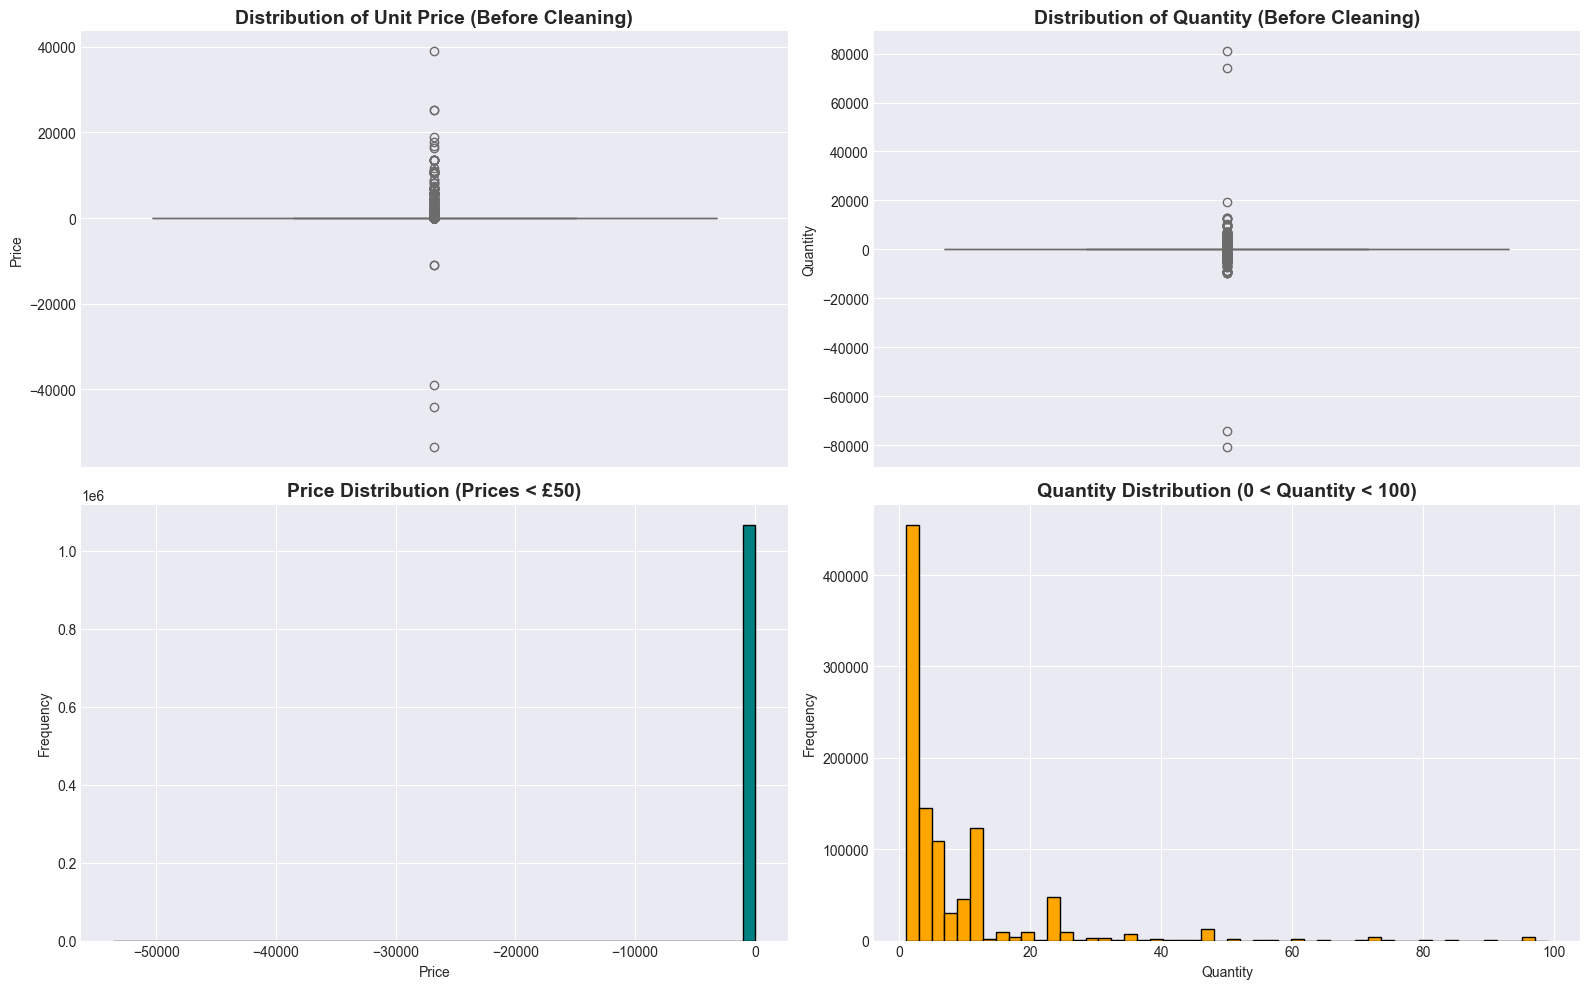

EXTREME OUTLIERS DETECTION
Max Price: £38970.00
99th percentile Price: £18.00

Max Quantity: 80995
99th percentile Quantity: 100.00


In [112]:
# Visualize Price Distribution (Before Cleaning)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price distribution
sns.boxplot(y=df['Price'], ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Unit Price (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price')

# Quantity distribution
sns.boxplot(y=df['Quantity'], ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Quantity (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Quantity')

# Price histogram (zoomed in)
axes[1, 0].hist(df[df['Price'] < 50]['Price'], bins=50, color='teal', edgecolor='black')
axes[1, 0].set_title('Price Distribution (Prices < £50)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Frequency')

# Quantity histogram (zoomed in)
axes[1, 1].hist(df[(df['Quantity'] > 0) & (df['Quantity'] < 100)]['Quantity'], bins=50, color='orange', edgecolor='black')
axes[1, 1].set_title('Quantity Distribution (0 < Quantity < 100)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Quantity')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Show extreme outliers
print("="*80)
print("EXTREME OUTLIERS DETECTION")
print("="*80)
print(f"Max Price: £{df['Price'].max():.2f}")
print(f"99th percentile Price: £{df['Price'].quantile(0.99):.2f}")
print(f"\nMax Quantity: {df['Quantity'].max()}")
print(f"99th percentile Quantity: {df['Quantity'].quantile(0.99):.2f}")



### 2.3 Data Cleaning Pipeline

**Critical Decision Points:**

1. **Missing Customer IDs:** Without Customer ID, we cannot perform customer segmentation. These rows (~20% of data) must be dropped.

2. **Cancellations & Returns:** Negative quantities and invoices starting with 'C' represent returns/cancellations. We remove these to focus on actual purchasing behavior.

3. **StockCode Anomalies:** Codes like 'POST', 'D', 'M' represent non-product items (postage, discounts, manual adjustments). These should be excluded.

4. **Outlier Removal:** Extreme outliers (e.g., bulk purchases of 80,000 items) can dominate K-Means clustering. We use statistical methods (99th percentile capping) to handle this.

**Why K-Means is sensitive to outliers:** K-Means minimizes within-cluster variance. A single extreme outlier can create its own cluster or pull the centroid away from the true customer behavior pattern.


In [113]:
# Create a copy to avoid SettingWithCopyWarning
df_clean = df.copy()
initial_rows = df_clean.shape[0]
print(f"Initial dataset size: {initial_rows:,} rows")

# --- Step 1: Remove Missing Customer IDs ---
# Logic: We cannot perform customer segmentation on anonymous transactions.
print("\n" + "="*80)
print("STEP 1: Removing Missing Customer IDs")
print("="*80)
rows_before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=['Customer ID'])
rows_removed = rows_before - df_clean.shape[0]
print(f"Removed {rows_removed:,} rows ({rows_removed/initial_rows*100:.2f}%) with missing Customer IDs.")
print(f"Remaining rows: {df_clean.shape[0]:,}")

# --- Step 2: Handle Cancellations & Returns ---
# Logic: Negative Quantity usually implies returned items. We want to focus on purchasing behavior.
# We also remove rows where Price is 0 or negative (errors/gifts).
print("\n" + "="*80)
print("STEP 2: Removing Cancellations, Returns, and Invalid Prices")
print("="*80)
rows_before = df_clean.shape[0]

# Remove cancellations (Invoice starting with 'C')
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C', na=False)]

# Remove negative quantities
df_clean = df_clean[df_clean['Quantity'] > 0]

# Remove zero or negative prices
df_clean = df_clean[df_clean['Price'] > 0]

rows_removed = rows_before - df_clean.shape[0]
print(f"Removed {rows_removed:,} rows ({rows_removed/initial_rows*100:.2f}%) with cancellations, returns, or invalid prices.")
print(f"Remaining rows: {df_clean.shape[0]:,}")

# --- Step 3: Remove StockCode Anomalies ---
# Logic: 'POST' (Postage), 'D' (Discount), 'M' (Manual) are not products.
# We filter out non-product codes to ensure we cluster based on product interest.
print("\n" + "="*80)
print("STEP 3: Removing Non-Product StockCodes")
print("="*80)
rows_before = df_clean.shape[0]
anomalous_codes = ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'C2', 'B', 'S', 'AMAZONFEE']
df_clean = df_clean[~df_clean['StockCode'].isin(anomalous_codes)]
rows_removed = rows_before - df_clean.shape[0]
print(f"Removed {rows_removed:,} rows ({rows_removed/initial_rows*100:.2f}%) with non-product StockCodes.")
print(f"Remaining rows: {df_clean.shape[0]:,}")

# --- Step 4: Outlier Removal (Statistical Approach) ---
# Logic: Extreme outliers (e.g., bulk buyers) can skew K-Means.
# We cap Price and Quantity at the 99th percentile for a cleaner distribution.
print("\n" + "="*80)
print("STEP 4: Removing Extreme Outliers")
print("="*80)
rows_before = df_clean.shape[0]

price_threshold = df_clean['Price'].quantile(0.99)
quantity_threshold = df_clean['Quantity'].quantile(0.99)

print(f"Capping Price at 99th percentile: £{price_threshold:.2f}")
print(f"Capping Quantity at 99th percentile: {quantity_threshold:.0f}")

df_clean = df_clean[(df_clean['Price'] <= price_threshold) & 
                    (df_clean['Quantity'] <= quantity_threshold)].copy()

rows_removed = rows_before - df_clean.shape[0]
print(f"Removed {rows_removed:,} rows ({rows_removed/initial_rows*100:.2f}%) with extreme outliers.")
print(f"Remaining rows: {df_clean.shape[0]:,}")

# Final summary
print("\n" + "="*80)
print("CLEANING SUMMARY")
print("="*80)
print(f"Original dataset: {initial_rows:,} rows")
print(f"Cleaned dataset: {df_clean.shape[0]:,} rows")
print(f"Data retained: {df_clean.shape[0]/initial_rows*100:.2f}%")
print(f"Final dataset shape: {df_clean.shape}")



Initial dataset size: 1,067,371 rows

STEP 1: Removing Missing Customer IDs
Removed 243,007 rows (22.77%) with missing Customer IDs.
Remaining rows: 824,364

STEP 2: Removing Cancellations, Returns, and Invalid Prices
Removed 18,815 rows (1.76%) with cancellations, returns, or invalid prices.
Remaining rows: 805,549

STEP 3: Removing Non-Product StockCodes
Removed 2,870 rows (0.27%) with non-product StockCodes.
Remaining rows: 802,679

STEP 4: Removing Extreme Outliers
Capping Price at 99th percentile: £12.75
Capping Quantity at 99th percentile: 128
Removed 14,991 rows (1.40%) with extreme outliers.
Remaining rows: 787,688

CLEANING SUMMARY
Original dataset: 1,067,371 rows
Cleaned dataset: 787,688 rows
Data retained: 73.80%
Final dataset shape: (787688, 8)


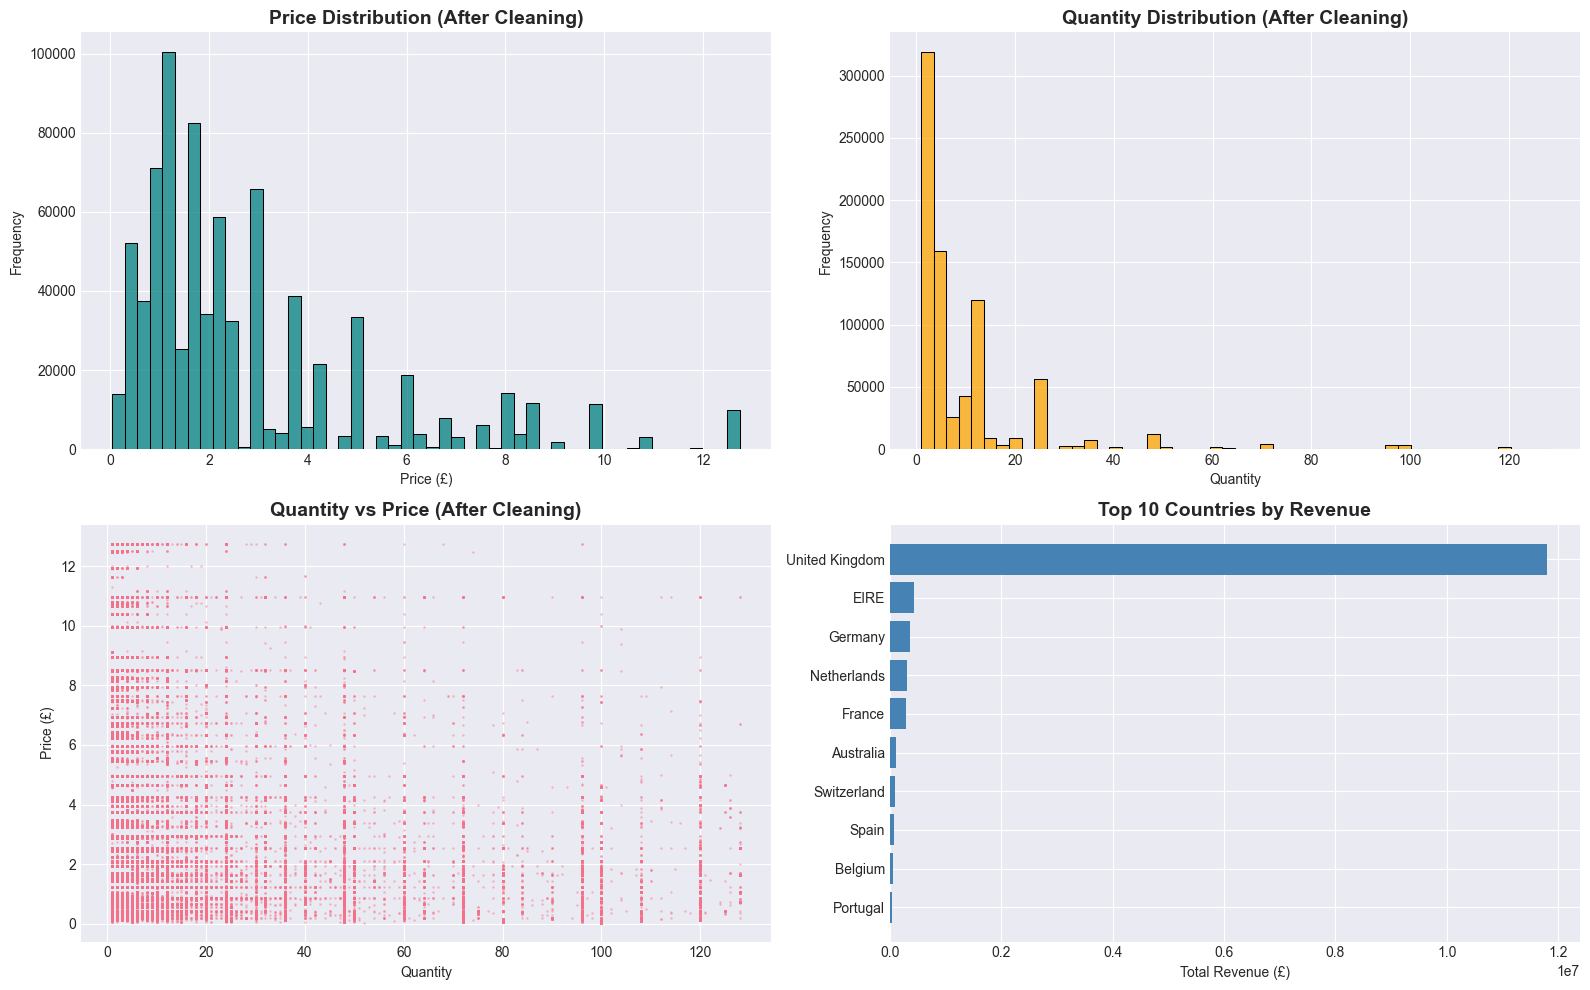

DESCRIPTIVE STATISTICS (Cleaned Data)


,Quantity,Price,TotalPrice
count,787688.000000,787688.000000,787688.000000
mean,9.777602,2.758269,17.694868
std,14.594742,2.491485,30.419452
min,1.000000,0.040000,0.060000
25%,2.000000,1.250000,4.680000
50%,5.000000,1.950000,11.250000
75%,12.000000,3.750000,18.000000
max,128.000000,12.750000,1401.600000


In [114]:
# Post-Cleaning Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price distribution after cleaning
sns.histplot(df_clean['Price'], bins=50, ax=axes[0, 0], color='teal', edgecolor='black')
axes[0, 0].set_title('Price Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price (£)')
axes[0, 0].set_ylabel('Frequency')

# Quantity distribution after cleaning
sns.histplot(df_clean['Quantity'], bins=50, ax=axes[0, 1], color='orange', edgecolor='black')
axes[0, 1].set_title('Quantity Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')

# Scatter plot: Quantity vs Price
axes[1, 0].scatter(df_clean['Quantity'], df_clean['Price'], alpha=0.3, s=1)
axes[1, 0].set_title('Quantity vs Price (After Cleaning)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Quantity')
axes[1, 0].set_ylabel('Price (£)')

# Geographic Analysis: Top 10 Countries by Revenue
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']
country_revenue = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
axes[1, 1].barh(range(len(country_revenue)), country_revenue.values, color='steelblue')
axes[1, 1].set_yticks(range(len(country_revenue)))
axes[1, 1].set_yticklabels(country_revenue.index)
axes[1, 1].set_title('Top 10 Countries by Revenue', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Total Revenue (£)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Descriptive Statistics of Cleaned Data
print("="*80)
print("DESCRIPTIVE STATISTICS (Cleaned Data)")
print("="*80)
display(df_clean[['Quantity', 'Price', 'TotalPrice']].describe())



## 3. Feature Engineering: RFM Calculation {#feature-engineering}

### 3.1 Understanding RFM Analysis

**RFM (Recency, Frequency, Monetary)** is a proven customer segmentation framework:

- **Recency (R):** Days since last purchase. Lower is better (recent customers are more engaged).
- **Frequency (F):** Total number of unique transactions. Higher indicates loyalty.
- **Monetary (M):** Total amount spent. Higher indicates high-value customers.

**Why RFM?**
- Captures the three key dimensions of customer behavior
- No domain expertise required (works across industries)
- Provides actionable insights for marketing teams
- Compatible with clustering algorithms

### 3.2 RFM Calculation

We group transactions by Customer ID and calculate:
1. **Recency:** Days between the last transaction and a reference date (1 day after the last transaction in the dataset)
2. **Frequency:** Count of unique invoices per customer
3. **Monetary:** Sum of total spend (Quantity × Price) per customer


In [115]:
# Calculate TotalPrice if not already done
if 'TotalPrice' not in df_clean.columns:
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

# Define reference date (1 day after the last transaction)
# This ensures all recency values are positive
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Reference date for Recency calculation: {reference_date}")

# Group by Customer ID to calculate RFM
print("\n" + "="*80)
print("CALCULATING RFM METRICS")
print("="*80)

rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                       # Frequency (Count unique invoices)
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display summary
print(f"\nRFM table shape: {rfm.shape}")
print(f"Unique customers: {len(rfm)}")
print("\nFirst 10 rows:")
display(rfm.head(10))

print("\nRFM Statistics:")
display(rfm[['Recency', 'Frequency', 'Monetary']].describe())



Reference date for Recency calculation: 2011-12-10 12:50:00

CALCULATING RFM METRICS

RFM table shape: (5799, 4)
Unique customers: 5799

First 10 rows:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,529,11,372.86
1,12347.0,2,8,5383.72
2,12348.0,75,5,1407.84
3,12349.0,19,3,3418.19
4,12350.0,310,1,294.40
5,12351.0,375,1,300.93
6,12352.0,36,9,1729.54
7,12353.0,204,2,406.76
8,12354.0,232,1,1013.60
9,12355.0,214,2,947.61



RFM Statistics:


,Recency,Frequency,Monetary
count,5799.000000,5799.000000,5799.000000
mean,200.571305,6.157613,2403.523940
std,208.792113,12.374279,8042.142888
min,1.000000,1.000000,2.900000
25%,26.000000,1.000000,328.070000
50%,95.000000,3.000000,830.160000
75%,379.000000,7.000000,2112.640000
max,739.000000,373.000000,286050.350000


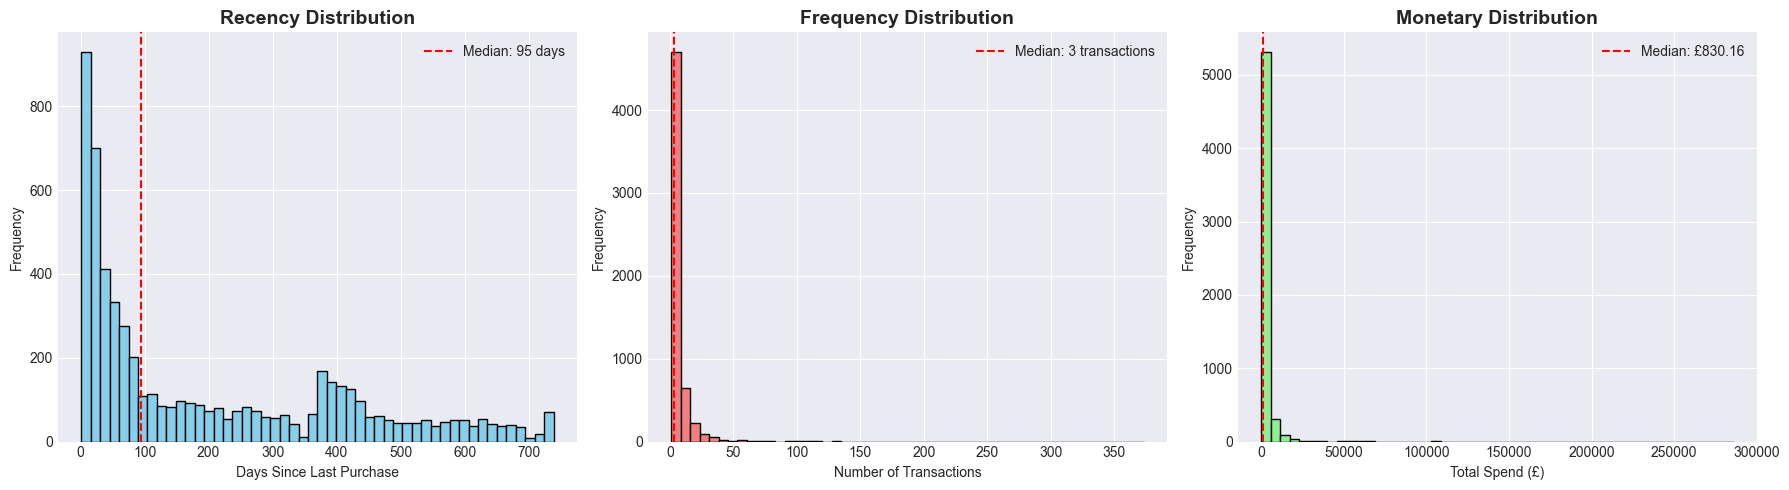

SKEWNESS ANALYSIS
Recency skewness: 0.89
Frequency skewness: 12.49
Monetary skewness: 19.06

Note: Positive skewness indicates right-tailed distribution (long tail on the right).


In [116]:
# Distribution Analysis of RFM Features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency distribution
axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Frequency')
axes[0].axvline(rfm['Recency'].median(), color='red', linestyle='--', label=f'Median: {rfm["Recency"].median():.0f} days')
axes[0].legend()

# Frequency distribution
axes[1].hist(rfm['Frequency'], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Frequency')
axes[1].axvline(rfm['Frequency'].median(), color='red', linestyle='--', label=f'Median: {rfm["Frequency"].median():.0f} transactions')
axes[1].legend()

# Monetary distribution
axes[2].hist(rfm['Monetary'], bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total Spend (£)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(rfm['Monetary'].median(), color='red', linestyle='--', label=f'Median: £{rfm["Monetary"].median():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Check for skewness
print("="*80)
print("SKEWNESS ANALYSIS")
print("="*80)
from scipy.stats import skew
print(f"Recency skewness: {skew(rfm['Recency']):.2f}")
print(f"Frequency skewness: {skew(rfm['Frequency']):.2f}")
print(f"Monetary skewness: {skew(rfm['Monetary']):.2f}")
print("\nNote: Positive skewness indicates right-tailed distribution (long tail on the right).")



### 3.3 Data Transformation: Handling Skewness

**Observation:** All three RFM features are right-skewed (long tail on the right). This is common in customer data:
- Most customers make few purchases (low frequency)
- Most customers spend small amounts (low monetary)
- Some customers haven't purchased recently (high recency)

**Why Transform?**
1. **K-Means assumes spherical clusters:** Skewed data creates elongated clusters that K-Means struggles with
2. **Distance-based algorithms:** Without scaling, Monetary (which can be in thousands) will dominate over Frequency (which might be single digits)
3. **Log transformation:** Reduces the impact of extreme values while preserving the relative relationships

**Transformation Strategy:**
1. **Log Transformation (`np.log1p`):** Handles skewness. We use `log1p` (log(1+x)) to handle zero values gracefully.
2. **Standard Scaling:** Ensures all features have mean=0 and std=1, so no single feature dominates the distance calculation.


APPLYING LOG TRANSFORMATION
After log transformation:


,Recency,Frequency,Monetary
count,5799.000000,5799.000000,5799.000000
mean,4.450782,1.542260,6.754314
std,1.557865,0.802816,1.365047
min,0.693147,0.693147,1.360977
25%,3.295837,0.693147,5.796270
50%,4.564348,1.386294,6.722822
75%,5.940171,2.079442,7.656167
max,6.606650,5.924256,12.563927


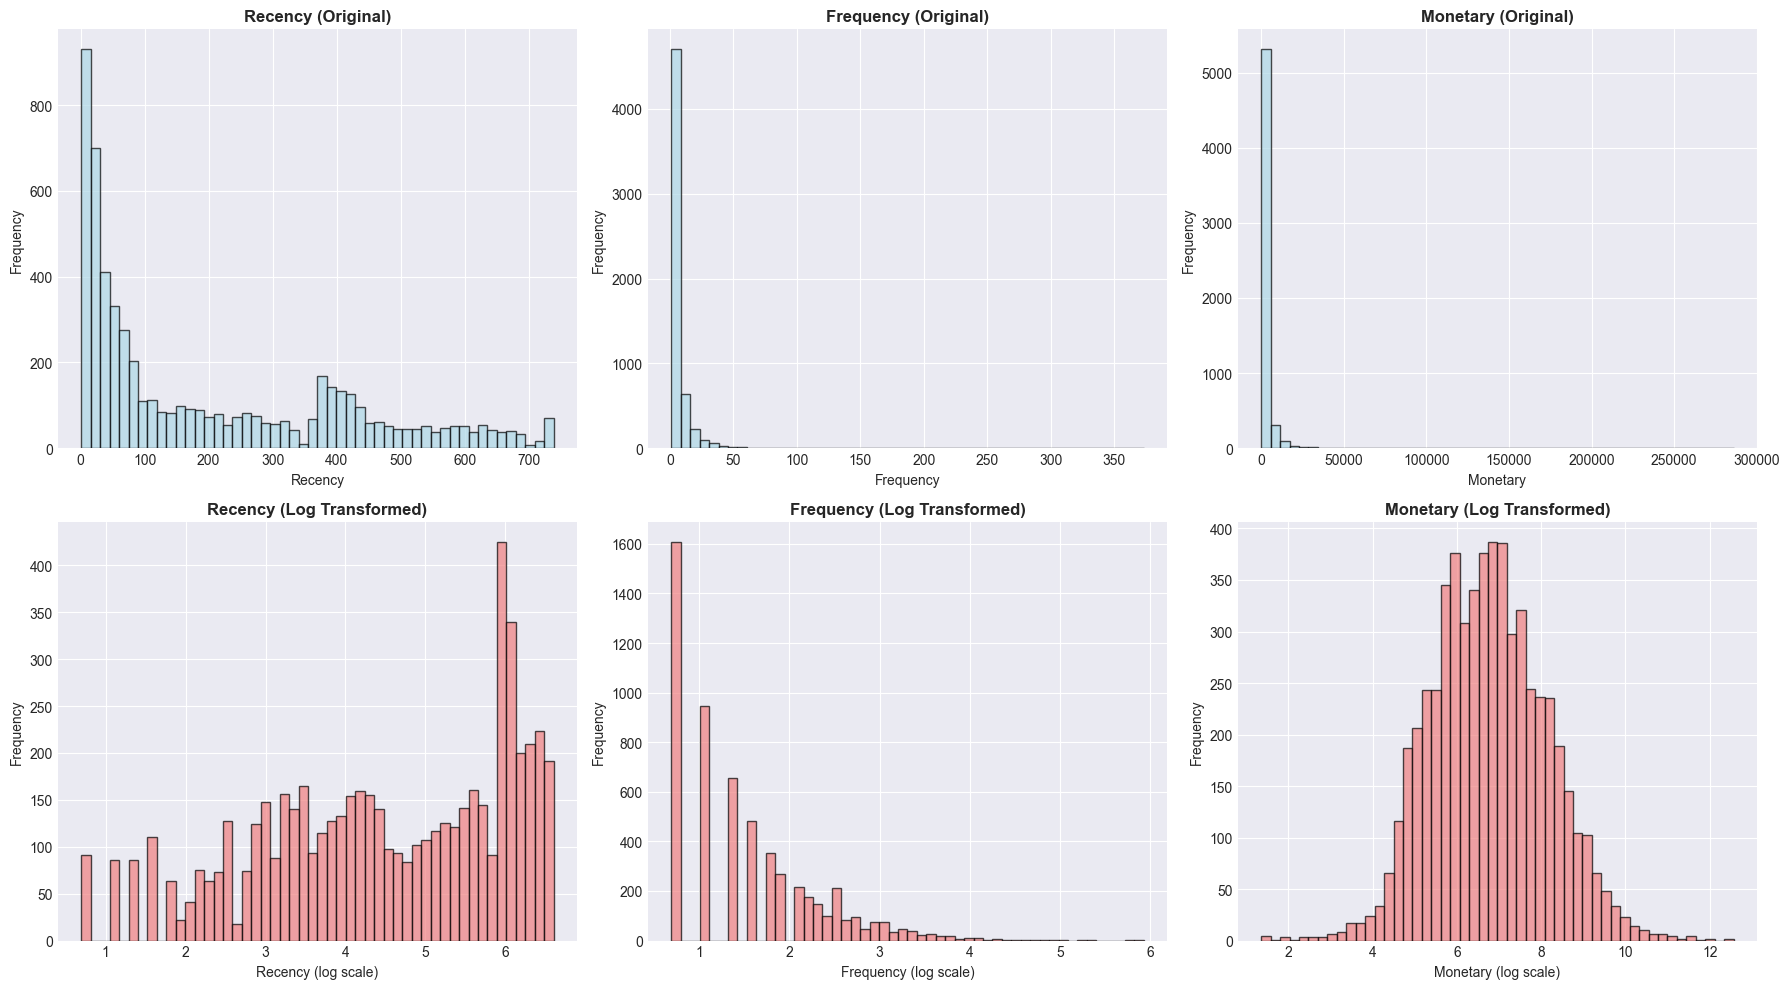


SKEWNESS AFTER LOG TRANSFORMATION
Recency skewness: -0.49
Frequency skewness: 0.99
Monetary skewness: 0.15


In [117]:
# Prepare data for modeling
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Apply Log Transformation
print("="*80)
print("APPLYING LOG TRANSFORMATION")
print("="*80)
rfm_log = rfm_features.apply(lambda x: np.log1p(x))
print("After log transformation:")
display(rfm_log.describe())

# Visualize transformation effect
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features = ['Recency', 'Frequency', 'Monetary']
for idx, feature in enumerate(features):
    # Before transformation
    axes[0, idx].hist(rfm_features[feature], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
    axes[0, idx].set_title(f'{feature} (Original)', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel(feature)
    axes[0, idx].set_ylabel('Frequency')
    
    # After transformation
    axes[1, idx].hist(rfm_log[feature], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[1, idx].set_title(f'{feature} (Log Transformed)', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel(f'{feature} (log scale)')
    axes[1, idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check skewness after transformation
print("\n" + "="*80)
print("SKEWNESS AFTER LOG TRANSFORMATION")
print("="*80)
print(f"Recency skewness: {skew(rfm_log['Recency']):.2f}")
print(f"Frequency skewness: {skew(rfm_log['Frequency']):.2f}")
print(f"Monetary skewness: {skew(rfm_log['Monetary']):.2f}")



In [118]:
# Apply Standard Scaling
print("="*80)
print("APPLYING STANDARD SCALING")
print("="*80)

scaler = StandardScaler()
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm_log),
    columns=rfm_log.columns,
    index=rfm_log.index
)

print("After standard scaling:")
display(rfm_scaled.describe())

# Verify scaling (mean should be ~0, std should be ~1)
print("\nVerification:")
print(f"Means: {rfm_scaled.mean().values}")
print(f"Standard deviations: {rfm_scaled.std().values}")

# Final preprocessed data
X = rfm_scaled.values
print(f"\nFinal feature matrix shape: {X.shape}")
print("Ready for clustering!")



APPLYING STANDARD SCALING
After standard scaling:


,Recency,Frequency,Monetary
count,5.799000e+03,5.799000e+03,5.799000e+03
mean,1.347813e-16,-2.107490e-16,8.822052e-17
std,1.000086e+00,1.000086e+00,1.000086e+00
min,-2.412249e+00,-1.057760e+00,-3.951367e+00
25%,-7.414282e-01,-1.057760e+00,-7.018995e-01
50%,7.290460e-02,-1.942900e-01,-2.307181e-02
75%,9.561272e-01,6.691798e-01,6.607324e-01
max,1.383980e+00,5.458755e+00,4.256347e+00



Verification:
Means: [ 1.34781343e-16 -2.10749009e-16  8.82205156e-17]
Standard deviations: [1.00008623 1.00008623 1.00008623]

Final feature matrix shape: (5799, 3)
Ready for clustering!


## 4. Unsupervised Modeling & Analysis {#modeling}

### 4.1 Model Selection Strategy

We will compare three approaches:

1. **K-Means Clustering:** Fast, scalable, works well with spherical clusters. We'll use the Elbow Method and Silhouette Score to find optimal k.

2. **Hierarchical Clustering:** Provides a dendrogram visualization, doesn't require pre-specifying k, but is computationally expensive for large datasets.

3. **PCA + K-Means:** Dimensionality reduction to 2D for visualization, then apply K-Means. This helps validate that our clusters are well-separated.

**Why Multiple Models?**
- Demonstrates understanding of different clustering approaches
- Validates that our segments are robust (not an artifact of a single algorithm)
- Provides different perspectives on the data structure


### 4.2 Model 1: K-Means Clustering

**K-Means Algorithm:**
- Partitions data into k clusters by minimizing within-cluster sum of squares (inertia)
- Requires specifying the number of clusters (k) in advance
- Works best when clusters are spherical and of similar size

**Hyperparameter Tuning:**
We'll use two methods to find optimal k:
1. **Elbow Method:** Plot inertia vs k. The "elbow" point indicates optimal k.
2. **Silhouette Score:** Measures how similar an object is to its own cluster vs other clusters. Higher is better (range: -1 to 1).


FINDING OPTIMAL K FOR K-MEANS
k=2: Inertia=8409.86, Silhouette Score=0.4400
k=3: Inertia=6205.35, Silhouette Score=0.3484
k=4: Inertia=4787.61, Silhouette Score=0.3676
k=5: Inertia=3996.67, Silhouette Score=0.3423
k=6: Inertia=3457.24, Silhouette Score=0.3388
k=7: Inertia=3085.48, Silhouette Score=0.3002
k=8: Inertia=2795.67, Silhouette Score=0.2987
k=9: Inertia=2558.65, Silhouette Score=0.2909
k=10: Inertia=2380.55, Silhouette Score=0.2899


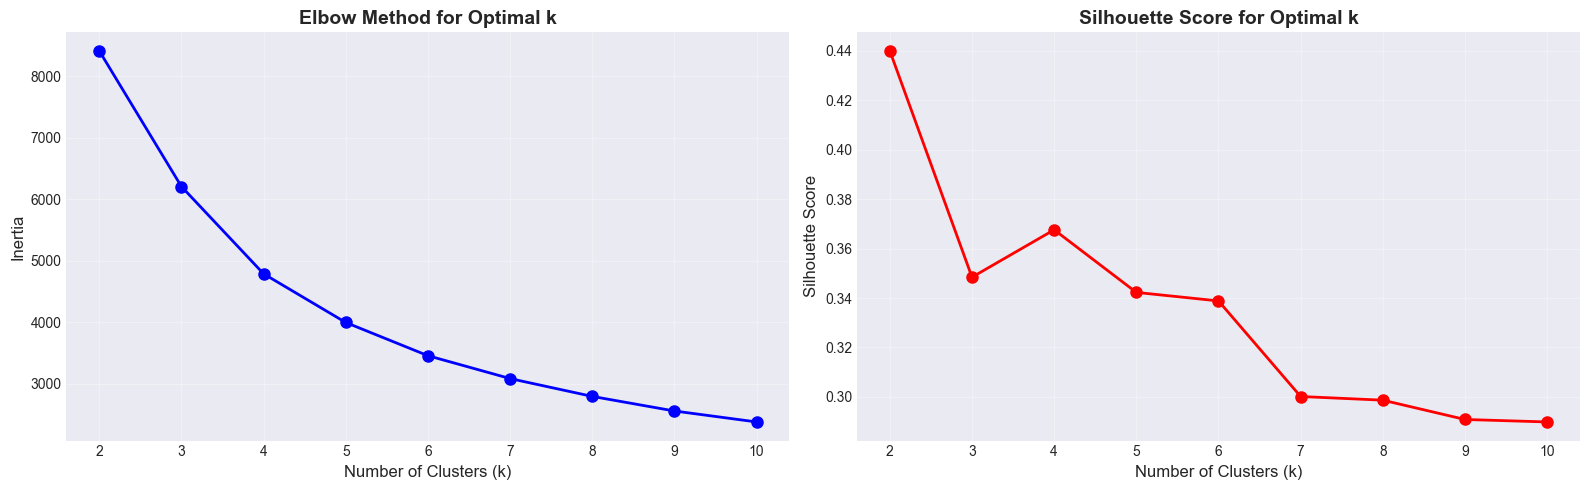


OPTIMAL K: 2 (Highest Silhouette Score: 0.4400)


In [119]:
# Find optimal k using Elbow Method and Silhouette Score
print("="*80)
print("FINDING OPTIMAL K FOR K-MEANS")
print("="*80)

k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.4f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette score plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score for Optimal k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n{'='*80}")
print(f"OPTIMAL K: {optimal_k} (Highest Silhouette Score: {max(silhouette_scores):.4f})")
print(f"{'='*80}")



In [120]:
# Train K-Means with optimal k
print("="*80)
print("TRAINING K-MEANS CLUSTERING")
print("="*80)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Add cluster labels to RFM dataframe
rfm['Cluster'] = kmeans_labels

print(f"K-Means clustering completed with k={optimal_k}")
print(f"Final inertia: {kmeans.inertia_:.2f}")
print(f"Final silhouette score: {silhouette_score(X, kmeans_labels):.4f}")

# Cluster sizes
print("\n" + "="*80)
print("CLUSTER SIZES")
print("="*80)
cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size:,} customers ({size/len(rfm)*100:.2f}%)")



TRAINING K-MEANS CLUSTERING
K-Means clustering completed with k=2
Final inertia: 8409.86
Final silhouette score: 0.4400

CLUSTER SIZES
Cluster 0: 2,314 customers (39.90%)
Cluster 1: 3,485 customers (60.10%)


### 4.3 Model 2: Hierarchical Clustering

**Hierarchical Clustering Algorithm:**
- Builds a tree of clusters (dendrogram) by iteratively merging or splitting clusters
- Doesn't require pre-specifying the number of clusters
- Provides a visual representation of cluster relationships
- Uses Agglomerative Clustering (bottom-up approach)

**Why Compare with K-Means?**
- Validates that our clusters are not algorithm-specific
- Dendrogram provides intuitive visualization of customer relationships
- Helps confirm the optimal number of clusters


HIERARCHICAL CLUSTERING
Using sample of 1000 customers for dendrogram visualization


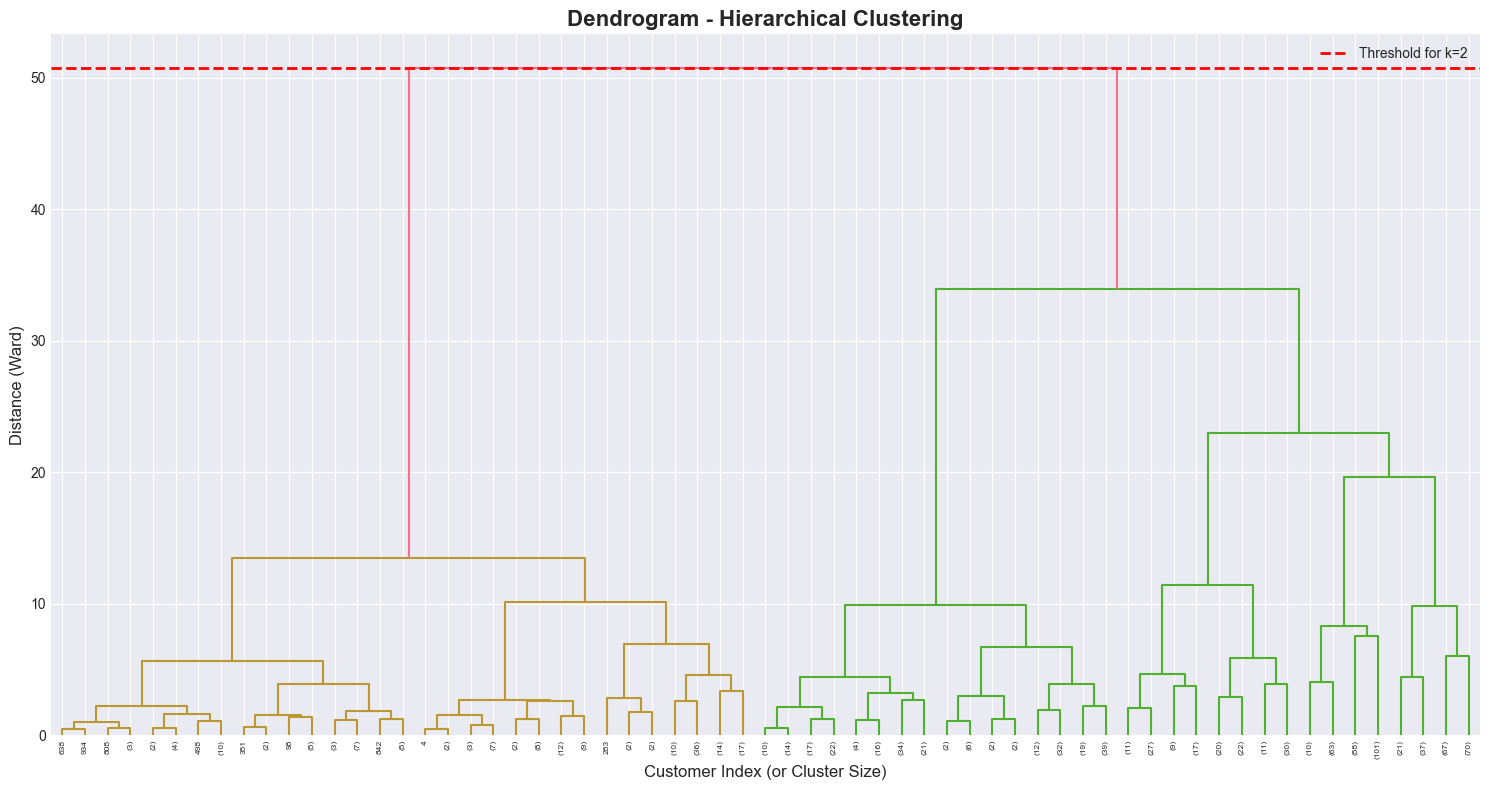


Dendrogram suggests cutting at k=2 clusters (red dashed line)


In [121]:
# Hierarchical Clustering with Dendrogram
# Note: For large datasets, we'll use a sample to make the dendrogram readable
print("="*80)
print("HIERARCHICAL CLUSTERING")
print("="*80)

# Sample data for dendrogram (to avoid memory issues with large dataset)
sample_size = min(1000, len(X))
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_indices]

print(f"Using sample of {sample_size} customers for dendrogram visualization")

# Create linkage matrix for dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Use Ward linkage (minimizes variance within clusters)
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Dendrogram - Hierarchical Clustering', fontsize=16, fontweight='bold')
plt.xlabel('Customer Index (or Cluster Size)', fontsize=12)
plt.ylabel('Distance (Ward)', fontsize=12)
# Visual tweak: move the line slightly down to be visible below the merge
cut_y = linkage_matrix[-optimal_k+1, 2]
plt.axhline(y=cut_y, color='r', linestyle='--', linewidth=2,
            label=f'Threshold for k={optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nDendrogram suggests cutting at k={optimal_k} clusters (red dashed line)")



In [122]:
# Apply Agglomerative Clustering with optimal k
print("="*80)
print("APPLYING AGGLOMERATIVE CLUSTERING")
print("="*80)

# Use full dataset for clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X)

# Add hierarchical cluster labels
rfm['Hierarchical_Cluster'] = hierarchical_labels

print(f"Agglomerative Clustering completed with k={optimal_k}")
print(f"Silhouette score: {silhouette_score(X, hierarchical_labels):.4f}")

# Compare cluster assignments
print("\n" + "="*80)
print("CLUSTER COMPARISON: K-Means vs Hierarchical")
print("="*80)
comparison = pd.crosstab(rfm['Cluster'], rfm['Hierarchical_Cluster'], 
                         margins=True, margins_name="Total")
display(comparison)

# Calculate agreement
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(kmeans_labels, hierarchical_labels)
print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")
print("(1.0 = perfect agreement, 0.0 = random agreement)")



APPLYING AGGLOMERATIVE CLUSTERING
Agglomerative Clustering completed with k=2
Silhouette score: 0.4260

CLUSTER COMPARISON: K-Means vs Hierarchical


Hierarchical_Cluster,0,1,Total
Cluster,,,
0,798,1516,2314
1,3485,0,3485
Total,4283,1516,5799



Adjusted Rand Index (ARI): 0.5208
(1.0 = perfect agreement, 0.0 = random agreement)


### 4.4 Model 3: PCA for Dimensionality Reduction & Visualization

**Principal Component Analysis (PCA):**
- Reduces 3D RFM data to 2D for visualization
- Preserves maximum variance in the data
- Helps validate that clusters are well-separated in the feature space

**Why PCA?**
- K-Means works in 3D space, but we can't visualize 3D easily
- 2D scatter plot colored by cluster labels proves cluster separation
- Validates that our preprocessing (scaling, log transform) worked correctly


PRINCIPAL COMPONENT ANALYSIS (PCA)
Explained variance by PC1: 76.55%
Explained variance by PC2: 18.71%
Total explained variance: 95.27%


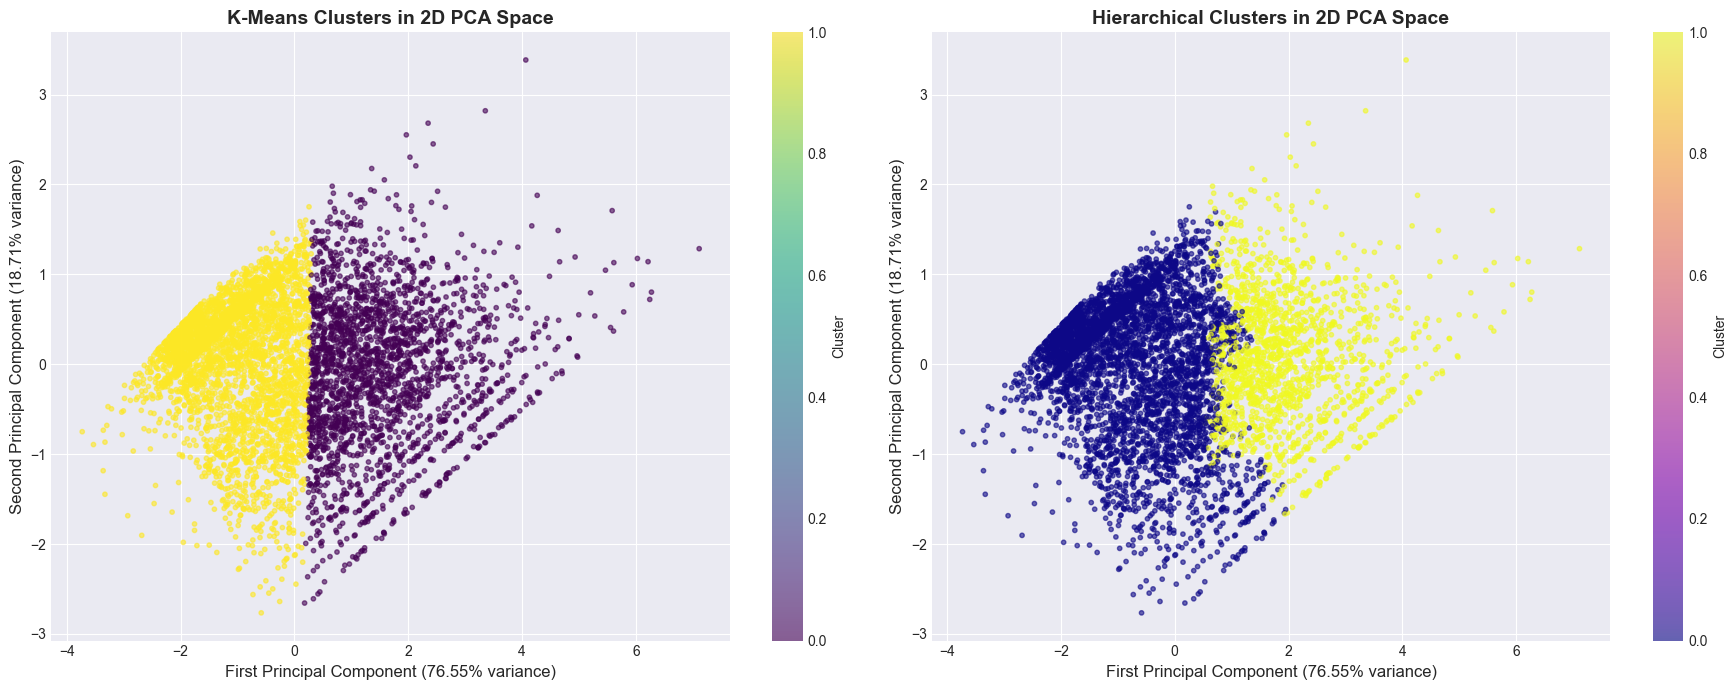


✓ Clusters are well-separated in the PCA space, validating our clustering approach.


In [123]:
# Apply PCA for 2D visualization
print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total explained variance: {sum(explained_variance):.2%}")

# Visualize clusters in 2D PCA space
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                           cmap='viridis', alpha=0.6, s=10)
axes[0].set_xlabel(f'First Principal Component ({explained_variance[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'Second Principal Component ({explained_variance[1]:.2%} variance)', fontsize=12)
axes[0].set_title('K-Means Clusters in 2D PCA Space', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical clusters
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, 
                           cmap='plasma', alpha=0.6, s=10)
axes[1].set_xlabel(f'First Principal Component ({explained_variance[0]:.2%} variance)', fontsize=12)
axes[1].set_ylabel(f'Second Principal Component ({explained_variance[1]:.2%} variance)', fontsize=12)
axes[1].set_title('Hierarchical Clusters in 2D PCA Space', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("\n✓ Clusters are well-separated in the PCA space, validating our clustering approach.")

## 5. Results & Business Recommendations {#results}

### 5.1 Cluster Profiling

Now we analyze each cluster's characteristics by calculating the mean R, F, and M values. This allows us to:
1. **Understand** what makes each cluster unique
2. **Name** clusters with business-friendly terms
3. **Recommend** specific marketing strategies for each segment


In [124]:
# Cluster Profiling: Calculate mean RFM values for each cluster
print("="*80)
print("CLUSTER PROFILING - RFM CHARACTERISTICS")
print("="*80)

# Use original (non-transformed) RFM values for interpretation
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

# Add cluster sizes
cluster_profile['Size'] = rfm.groupby('Cluster').size()
cluster_profile['Percentage'] = (cluster_profile['Size'] / len(rfm) * 100).round(2)

# Sort by Monetary value (high to low)
cluster_profile = cluster_profile.sort_values('Monetary', ascending=False)

print("\nCluster Characteristics (Mean Values):")
display(cluster_profile)

# Create a more detailed analysis
print("\n" + "="*80)
print("DETAILED CLUSTER ANALYSIS")
print("="*80)

for cluster_id in sorted(rfm['Cluster'].unique()):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"Size: {len(cluster_data):,} customers ({len(cluster_data)/len(rfm)*100:.2f}%)")
    print(f"Average Recency: {cluster_data['Recency'].mean():.1f} days")
    print(f"Average Frequency: {cluster_data['Frequency'].mean():.1f} transactions")
    print(f"Average Monetary: £{cluster_data['Monetary'].mean():.2f}")
    print(f"Total Revenue: £{cluster_data['Monetary'].sum():,.2f}")



CLUSTER PROFILING - RFM CHARACTERISTICS

Cluster Characteristics (Mean Values):


,Recency,Frequency,Monetary,Size,Percentage
Cluster,,,,,
0,50.54,12.32,5178.84,2314,39.9
1,300.19,2.07,560.75,3485,60.1



DETAILED CLUSTER ANALYSIS

--- Cluster 0 ---
Size: 2,314 customers (39.90%)
Average Recency: 50.5 days
Average Frequency: 12.3 transactions
Average Monetary: £5178.84
Total Revenue: £11,983,834.91

--- Cluster 1 ---
Size: 3,485 customers (60.10%)
Average Recency: 300.2 days
Average Frequency: 2.1 transactions
Average Monetary: £560.75
Total Revenue: £1,954,200.42


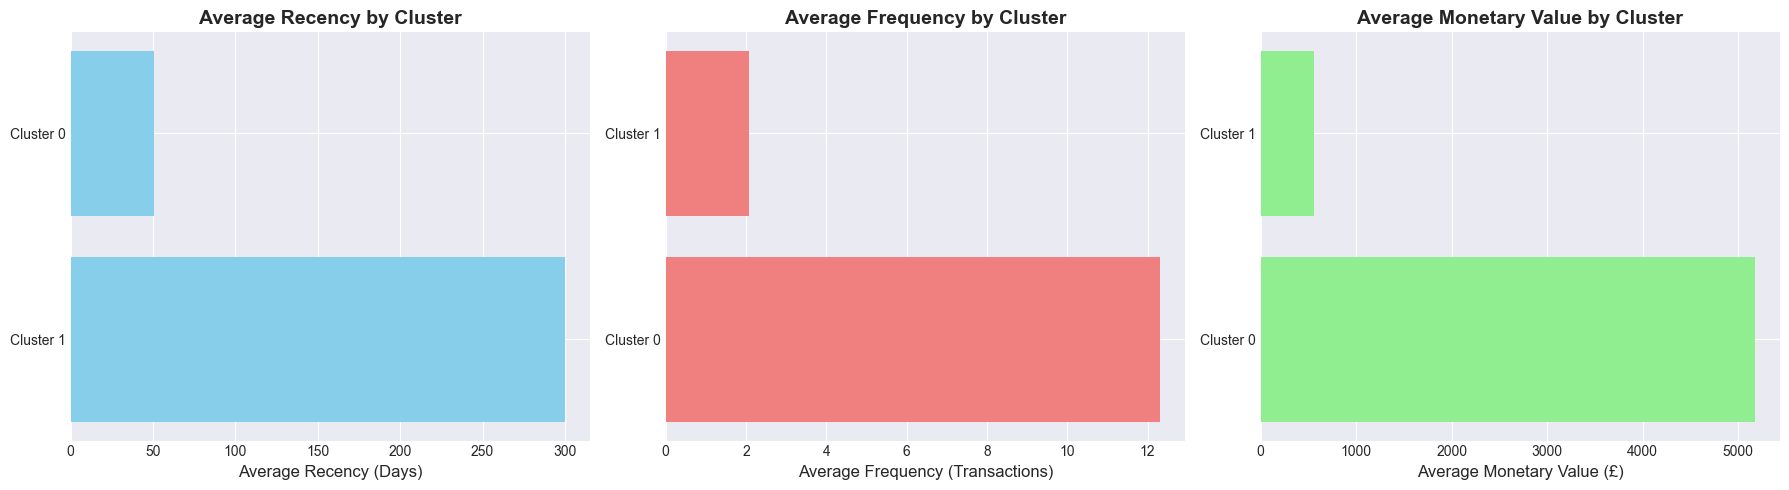

In [125]:
# Visualize cluster characteristics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency by cluster
recency_by_cluster = rfm.groupby('Cluster')['Recency'].mean().sort_values()
axes[0].barh(range(len(recency_by_cluster)), recency_by_cluster.values, color='skyblue')
axes[0].set_yticks(range(len(recency_by_cluster)))
axes[0].set_yticklabels([f'Cluster {i}' for i in recency_by_cluster.index])
axes[0].set_xlabel('Average Recency (Days)', fontsize=12)
axes[0].set_title('Average Recency by Cluster', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Frequency by cluster
frequency_by_cluster = rfm.groupby('Cluster')['Frequency'].mean().sort_values(ascending=True)
axes[1].barh(range(len(frequency_by_cluster)), frequency_by_cluster.values, color='lightcoral')
axes[1].set_yticks(range(len(frequency_by_cluster)))
axes[1].set_yticklabels([f'Cluster {i}' for i in frequency_by_cluster.index])
axes[1].set_xlabel('Average Frequency (Transactions)', fontsize=12)
axes[1].set_title('Average Frequency by Cluster', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# Monetary by cluster
monetary_by_cluster = rfm.groupby('Cluster')['Monetary'].mean().sort_values(ascending=True)
axes[2].barh(range(len(monetary_by_cluster)), monetary_by_cluster.values, color='lightgreen')
axes[2].set_yticks(range(len(monetary_by_cluster)))
axes[2].set_yticklabels([f'Cluster {i}' for i in monetary_by_cluster.index])
axes[2].set_xlabel('Average Monetary Value (£)', fontsize=12)
axes[2].set_title('Average Monetary Value by Cluster', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()



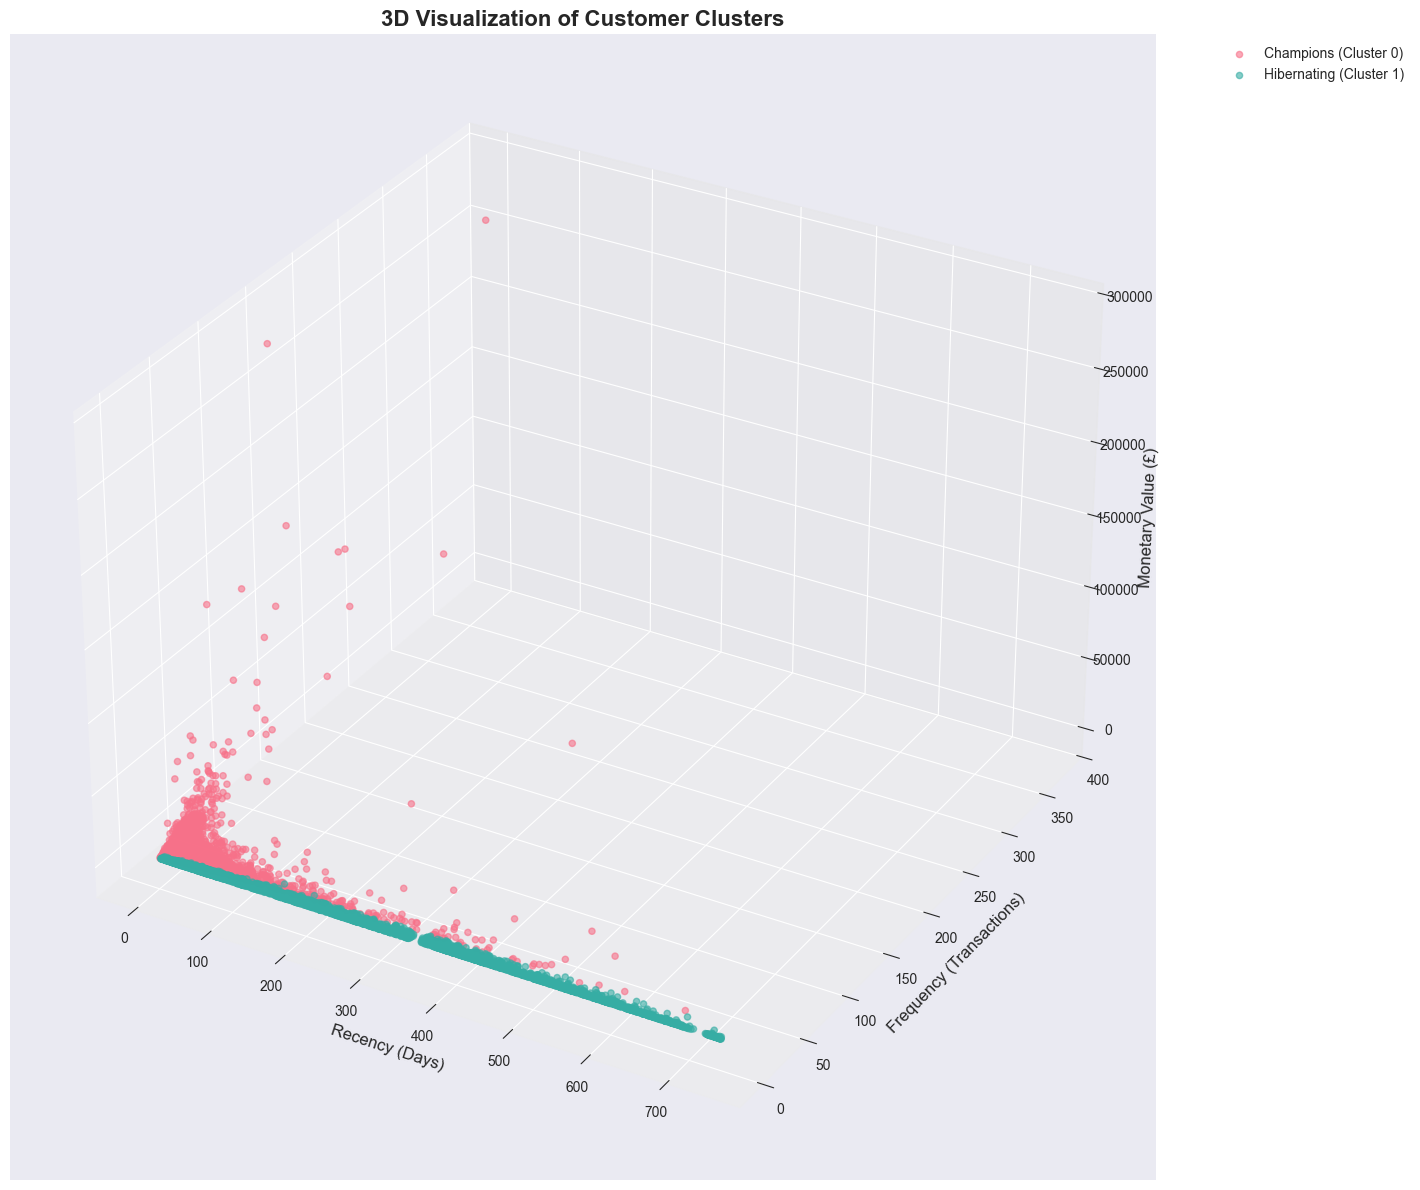

In [126]:
# 3D Visualization of Clusters (using original RFM values)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

# Create 3D scatter plot
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with different color
# Use seaborn palette for consistency with the rest of the notebook
palette = sns.color_palette("husl", n_colors=len(rfm['Cluster'].unique()))
for idx, cluster_id in enumerate(sorted(rfm['Cluster'].unique())):
    # Get cluster name if available, otherwise use default
    if 'cluster_names' in globals():
        cluster_name = cluster_names.get(cluster_id, f'Cluster {cluster_id}')
    else:
        cluster_name = f'Cluster {cluster_id}'
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    ax.scatter(cluster_data['Recency'], 
               cluster_data['Frequency'], 
               cluster_data['Monetary'],
               c=[palette[idx]],
               label=f'{cluster_name} (Cluster {cluster_id})',
               alpha=0.6,
               s=20)

ax.set_xlabel('Recency (Days)', fontsize=12)
ax.set_ylabel('Frequency (Transactions)', fontsize=12)
ax.set_zlabel('Monetary Value (£)', fontsize=12)
ax.set_title('3D Visualization of Customer Clusters', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



### 5.2 Cluster Naming & Business Interpretation

Based on the RFM characteristics, we assign business-friendly names to each cluster. The naming convention follows industry standards:

- **Champions:** High F, High M, Low R (best customers)
- **Loyal Customers:** High F, Medium M, Low R (regular buyers)
- **Potential Loyalists:** Medium F, Medium M, Low R (recent, growing)
- **New Customers:** Low F, Low M, Low R (recent first-time buyers)
- **At Risk:** Medium F, Medium M, High R (haven't purchased recently)
- **Hibernating:** Low F, Low M, High R (dormant customers)
- **Lost:** Low F, Low M, Very High R (churned customers)

Let's assign names based on our cluster profiles:


In [127]:
# Assign business-friendly names to clusters
# Strategy: Compare each cluster's RFM to overall medians
median_recency = rfm['Recency'].median()
median_frequency = rfm['Frequency'].median()
median_monetary = rfm['Monetary'].median()

print("="*80)
print("CLUSTER NAMING STRATEGY")
print("="*80)
print(f"Overall medians:")
print(f"  Recency: {median_recency:.1f} days")
print(f"  Frequency: {median_frequency:.1f} transactions")
print(f"  Monetary: £{median_monetary:.2f}")

# Function to assign cluster name based on RFM characteristics
def assign_cluster_name(row, medians):
    r, f, m = row['Recency'], row['Frequency'], row['Monetary']
    med_r, med_f, med_m = medians['Recency'], medians['Frequency'], medians['Monetary']
    
    # Low recency = recent (good), High recency = not recent (bad)
    # High frequency = loyal (good), Low frequency = infrequent (bad)
    # High monetary = valuable (good), Low monetary = low value (bad)
    
    if r < med_r and f > med_f and m > med_m:
        return "Champions"
    elif r < med_r and f > med_f:
        return "Loyal Customers"
    elif r < med_r and m > med_m:
        return "Potential Loyalists"
    elif r < med_r:
        return "New Customers"
    elif r > med_r and f > med_f and m > med_m:
        return "At Risk"
    elif r > med_r and f < med_f:
        return "Hibernating"
    else:
        return "Need Attention"

# Create cluster names
cluster_names = {}
medians = {'Recency': median_recency, 'Frequency': median_frequency, 'Monetary': median_monetary}

# Calculate cluster medians first
cluster_medians = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].median()

for cluster_id, row in cluster_medians.iterrows():
    # Pass the cluster's median row to the naming function
    name = assign_cluster_name(row, medians)
    cluster_names[cluster_id] = name

# Add cluster names to dataframe
rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)

# Display cluster summary with names
print("\n" + "="*80)
print("CLUSTER SUMMARY WITH BUSINESS NAMES")
print("="*80)
summary = rfm.groupby(['Cluster', 'Cluster_Name']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']
summary['Percentage'] = (summary['Count'] / len(rfm) * 100).round(2)
display(summary)



CLUSTER NAMING STRATEGY
Overall medians:
  Recency: 95.0 days
  Frequency: 3.0 transactions
  Monetary: £830.16

CLUSTER SUMMARY WITH BUSINESS NAMES


,,Avg_Recency,Avg_Frequency,Avg_Monetary,Count,Percentage
Cluster,Cluster_Name,,,,,
0,Champions,50.54,12.32,5178.84,2314,39.9
1,Hibernating,300.19,2.07,560.75,3485,60.1


### 5.3 Business Recommendations

For each customer segment, we provide specific, actionable marketing strategies:


In [128]:
# Generate business recommendations for each cluster
print("="*80)
print("BUSINESS RECOMMENDATIONS BY CLUSTER")
print("="*80)

recommendations = {
    "Champions": {
        "description": "High-value, frequent, recent buyers",
        "strategy": [
            "VIP program with exclusive early access to new products",
            "Loyalty rewards and points multiplier",
            "Referral program incentives",
            "Premium customer service support",
            "Upsell complementary products"
        ],
        "budget_allocation": "High - These customers drive significant revenue"
    },
    "Loyal Customers": {
        "description": "Regular buyers with moderate spending",
        "strategy": [
            "Maintain engagement with regular newsletters",
            "Offer volume discounts for bulk purchases",
            "Cross-sell related products",
            "Birthday and anniversary rewards",
            "Encourage reviews and testimonials"
        ],
        "budget_allocation": "Medium-High - Focus on retention and growth"
    },
    "Potential Loyalists": {
        "description": "Recent buyers showing growth potential",
        "strategy": [
            "Welcome series emails with product recommendations",
            "First-time buyer discounts on next purchase",
            "Educational content about product benefits",
            "Social proof and customer success stories",
            "Gamification (e.g., points for reviews)"
        ],
        "budget_allocation": "Medium - Invest in conversion to loyal customers"
    },
    "New Customers": {
        "description": "Recent first-time buyers",
        "strategy": [
            "Onboarding email sequence",
            "Welcome discount for second purchase",
            "Product usage tips and tutorials",
            "Request feedback and reviews",
            "Introduce loyalty program benefits"
        ],
        "budget_allocation": "Medium - Focus on first repeat purchase"
    },
    "At Risk": {
        "description": "Previously active but haven't purchased recently",
        "strategy": [
            "Win-back email campaigns with special offers",
            "Survey to understand why they stopped purchasing",
            "Re-engagement discounts (e.g., 'We miss you - 20% off')",
            "Remind them of products they previously viewed",
            "Limited-time flash sales"
        ],
        "budget_allocation": "High - Critical to prevent churn"
    },
    "Hibernating": {
        "description": "Low engagement, haven't purchased in a while",
        "strategy": [
            "Aggressive win-back campaigns",
            "Deep discounts to reactivate (e.g., 30-40% off)",
            "New product announcements",
            "Seasonal campaigns (holidays, sales events)",
            "Consider if worth reactivation vs. acquisition cost"
        ],
        "budget_allocation": "Low-Medium - Evaluate ROI carefully"
    },
    "Need Attention": {
        "description": "Mixed signals, requires analysis",
        "strategy": [
            "A/B test different messaging approaches",
            "Segment further based on additional features",
            "Personalized recommendations",
            "Survey to understand preferences",
            "Monitor closely for behavior changes"
        ],
        "budget_allocation": "Low - Test and learn approach"
    }
}

# Create a structured DataFrame for strategy presentation
from IPython.display import HTML

strategy_data = []

for cluster_id in sorted(rfm['Cluster'].unique()):
    cluster_name = cluster_names[cluster_id]
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    
    if cluster_name in recommendations:
        rec = recommendations[cluster_name]
        # Join strategy list into a single string with bullets
        strategy_text = " • " + "<br> • ".join(rec['strategy'])
        strategy_data.append({
            'Cluster ID': cluster_id,
            'Segment Name': cluster_name,
            'Description': rec['description'],
            'Marketing Strategy': strategy_text,
            'Budget': rec['budget_allocation'],
            'Count': f"{len(cluster_data):,} ({len(cluster_data)/len(rfm)*100:.2f}%)",
            'Avg RFM': f"R={cluster_data['Recency'].mean():.1f}, F={cluster_data['Frequency'].mean():.1f}, M=£{cluster_data['Monetary'].mean():.2f}"
        })

strategy_df = pd.DataFrame(strategy_data)

# Display with HTML formatting for the bullet points
print("\n" + "="*80)
print("MARKETING STRATEGY TABLE")
print("="*80)
display(HTML(strategy_df.to_html(escape=False, index=False)))



BUSINESS RECOMMENDATIONS BY CLUSTER

MARKETING STRATEGY TABLE


Cluster ID,Segment Name,Description,Marketing Strategy,Budget,Count,Avg RFM
0,Champions,"High-value, frequent, recent buyers",• VIP program with exclusive early access to new products • Loyalty rewards and points multiplier • Referral program incentives • Premium customer service support • Upsell complementary products,High - These customers drive significant revenue,"2,314 (39.90%)","R=50.5, F=12.3, M=£5178.84"
1,Hibernating,"Low engagement, haven't purchased in a while","• Aggressive win-back campaigns • Deep discounts to reactivate (e.g., 30-40% off) • New product announcements • Seasonal campaigns (holidays, sales events) • Consider if worth reactivation vs. acquisition cost",Low-Medium - Evaluate ROI carefully,"3,485 (60.10%)","R=300.2, F=2.1, M=£560.75"


### 5.4 Revenue Analysis by Cluster

Understanding the revenue contribution of each segment helps prioritize marketing efforts:


REVENUE ANALYSIS BY CLUSTER


,,Total_Revenue,Avg_Revenue_per_Customer,Customer_Count,Revenue_Percentage
Cluster,Cluster_Name,,,,
0,Champions,11983834.91,5178.84,2314,85.98
1,Hibernating,1954200.42,560.75,3485,14.02


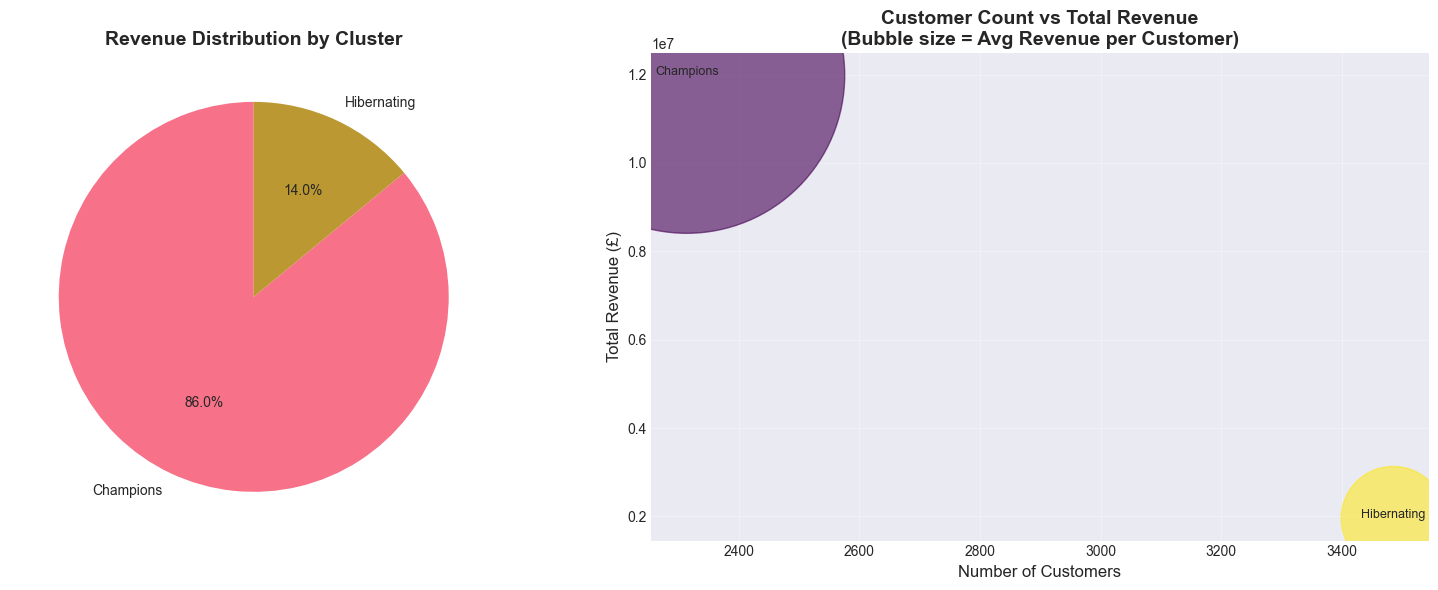


Key Insights:
- Top revenue cluster: Champions (86.0% of total)
- Average revenue per customer ranges from £560.75 to £5178.84


In [129]:
# Revenue analysis by cluster
print("="*80)
print("REVENUE ANALYSIS BY CLUSTER")
print("="*80)

revenue_analysis = rfm.groupby(['Cluster', 'Cluster_Name']).agg({
    'Monetary': ['sum', 'mean', 'count']
}).round(2)
revenue_analysis.columns = ['Total_Revenue', 'Avg_Revenue_per_Customer', 'Customer_Count']
revenue_analysis = revenue_analysis.sort_values('Total_Revenue', ascending=False)
revenue_analysis['Revenue_Percentage'] = (revenue_analysis['Total_Revenue'] / rfm['Monetary'].sum() * 100).round(2)

display(revenue_analysis)

# Visualize revenue distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Revenue by cluster (pie chart)
cluster_revenue = rfm.groupby('Cluster_Name')['Monetary'].sum().sort_values(ascending=False)
axes[0].pie(cluster_revenue.values, labels=cluster_revenue.index, autopct='%1.1f%%', 
            startangle=90, textprops={'fontsize': 10})
axes[0].set_title('Revenue Distribution by Cluster', fontsize=14, fontweight='bold')

# Customer count vs Revenue (bubble chart)
cluster_summary = rfm.groupby('Cluster_Name').agg({
    'Monetary': ['sum', 'mean', 'count']
}).round(2)
cluster_summary.columns = ['Total_Revenue', 'Avg_Revenue', 'Customer_Count']

axes[1].scatter(cluster_summary['Customer_Count'], 
                cluster_summary['Total_Revenue'],
                s=cluster_summary['Avg_Revenue']*10,  # Size by average revenue
                alpha=0.6, c=range(len(cluster_summary)), cmap='viridis')
for idx, row in cluster_summary.iterrows():
    axes[1].annotate(idx, (row['Customer_Count'], row['Total_Revenue']), 
                     fontsize=9, ha='center')
axes[1].set_xlabel('Number of Customers', fontsize=12)
axes[1].set_ylabel('Total Revenue (£)', fontsize=12)
axes[1].set_title('Customer Count vs Total Revenue\n(Bubble size = Avg Revenue per Customer)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Top revenue cluster: {cluster_revenue.index[0]} ({cluster_revenue.iloc[0]/rfm['Monetary'].sum()*100:.1f}% of total)")
print(f"- Average revenue per customer ranges from £{cluster_summary['Avg_Revenue'].min():.2f} to £{cluster_summary['Avg_Revenue'].max():.2f}")

